## Train Von Mises brain

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from VonMisesFunctions import *
from plotutils import *
from rnnmodel import *

### Create graphical model

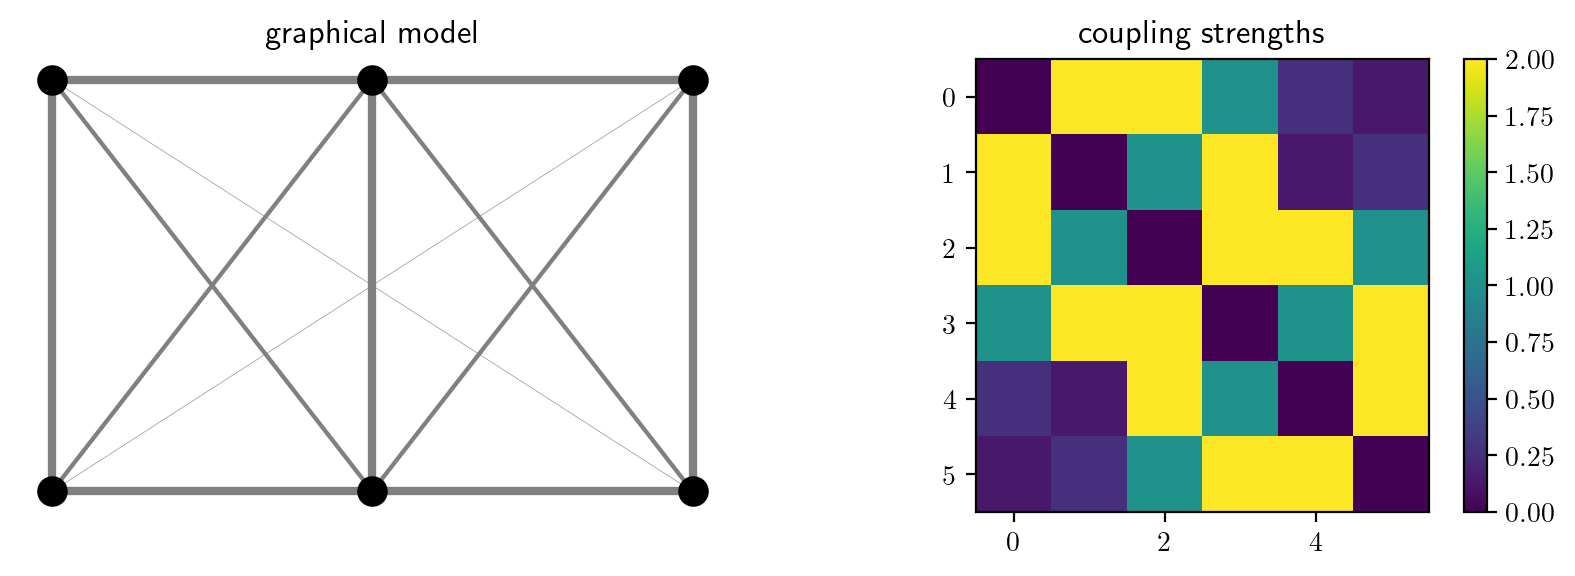

In [2]:
# create a grid structured graphical model
nrows, ncols = 2, 3
Ns = nrows*ncols # No. of variables

#c_spatial, c_strength, jitter =  1, 1, 0 # singleton potential strength, pairwise coupling spatial scale, max interaction strength, jitter in coupling strength
c_spatial, c_strength, jitter =  1.5, 2, 0 # singleton potential strength, pairwise coupling spatial scale, max interaction strength, jitter in coupling strength
J, node_positions = CreateGridGraphicalModel(ncols, nrows, c_spatial, c_strength, jitter)

AdjMat = (J[...,3] != 0)*1 # Adjacency matrix

DisplayGraphicalModel(J, node_positions,100)

### Generate input signal

In [3]:
B_train, B_test = 2500, 250 # no. of batches
T = 30                   # no. of time steps
T_low, T_high = 5, 10    # range of T_const = np. of time steps for which input is held constant
T_clip = 20              # no. of time steps to clip

Mu = GenerateDynamicMu(Ns, B_train+B_test, T_clip+T-1, T_low, T_high)

kappa_low  = 0.9 # baseline value of concentration parameters
kappa_high = 0.1 # factor by which to scale gamma distribtuion used to generate K 
Kappa = GenerateDynamicK(Ns, B_train+B_test, T_clip+T-1, T_low, T_high, kappa_low, kappa_high)

### Generate BP dynamics

Notation:  
y: local inputs/discrete local potentials  
x: discrete beliefs

In [4]:
N_bins = 21    # no. of discrete bins used to represent the belief of each variable
lam = 0.1  # relaxation parameter for BP dynamics

y, x = [], []

for b in tqdm(range(B_train + B_test)):
    Phi = DiscreteSingletonPotentials(N_bins, Kappa[b], Mu[b])
    Psi = DiscretePairwisePotentials(N_bins, Mu[b], J)
    y.append(Phi)
    x.append(DiscreteBP(Phi, Psi, AdjMat, T, lam, None)[1])
    
    
y = np.array(y)
y = y/np.sum(y[:,:,:,None,:],axis=2) # normalize local potentials
x = np.array(x)

y = ComputeCircularMomentsCat(y, N_bins)
x = ComputeCircularMomentsCat(x, N_bins)

# separate into training and test
y_test = y[B_train:]
x_test = x[B_train:]

y_train = y[0:B_train]
x_train = x[0:B_train]

del x, y

100%|██████████| 2750/2750 [03:26<00:00, 13.35it/s]


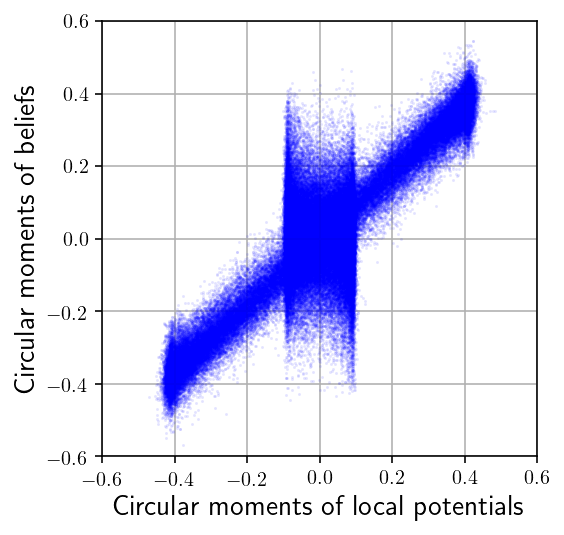

In [7]:
# scatter plot of input vs output
plt.plot(y_test[...,T_clip:].flatten(), x_test[...,T_clip+1:].flatten(),'b.',markersize=1,alpha=0.1)
plt.axis('square')
plt.axis([-.6,.6,-.6,.6])
plt.grid(True)
plt.xlabel('Circular moments of local potentials',fontsize=14)
plt.ylabel('Circular moments of beliefs',fontsize=14)
plt.show()

### Train RNN

In [8]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train_ = torch.tensor(y_train.transpose(0,2,1), dtype=torch.float32) # input signal
r_train_ = torch.tensor(x_train.transpose(0,2,1), dtype=torch.float32) # target neural activity

y_test_ = torch.tensor(y_test.transpose(0,2,1), dtype=torch.float32) # input signal
r_test_ = torch.tensor(x_test.transpose(0,2,1), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train_.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([2500, 50, 24])


In [9]:
"""
Create RNN module
"""

N_input, N_hidden, N_output = Ns*4, 400, Ns*4

use_cuda = True

brain = RNN(N_input, N_hidden, N_output, use_cuda)

loss_fn = nn.MSELoss()

if use_cuda and torch.cuda.is_available():
    brain.cuda()

In [10]:
NIters = 30000  # No. of iterations for training the RNN
batch_size = 200  # batch size for training the RNN
epoch = B_train//batch_size

learningrate = 5e-5
optimizer = optim.Adam(brain.parameters(), lr=learningrate, betas=(0.9, 0.999))

train_loss, test_loss = [], []

In [11]:
"""
Train the RNN
"""

t_st = time.time()
 
for iteration in range(NIters):
    
    optimizer.zero_grad()
    
    batch_index = torch.randint(0, B_train,(batch_size,))
    rhat_train_ = brain(y_train_[batch_index].cuda())[0]
    
    mse_train = loss_fn(r_train_[batch_index,T_clip:].cuda(), rhat_train_[:,T_clip:])
    
    mse_train.backward()  
    
    optimizer.step()
    
    if (iteration + 1) % epoch == 0:
        with torch.no_grad():
            rhat_test_ = brain(y_test_.cuda())[0]
            mse_test = loss_fn(r_test_[:,T_clip:].cuda(), rhat_test_[:,T_clip:])
            
        train_loss.append(mse_train.item())
        test_loss.append(mse_test.item())
        
    if (iteration + 1) % 2500 == 0:
        print('[%d] training loss: %.5f' %(iteration + 1, mse_train.item()))

print('Finished training')
t_en = time.time()
print('Time elapsed = %.2f mins' %((t_en - t_st)/60))

[2500] training loss: 0.00299
[5000] training loss: 0.00141
[7500] training loss: 0.00127
[10000] training loss: 0.00119
[12500] training loss: 0.00110
[15000] training loss: 0.00104
[17500] training loss: 0.00105
[20000] training loss: 0.00094
[22500] training loss: 0.00094
[25000] training loss: 0.00086
[27500] training loss: 0.00081
[30000] training loss: 0.00072
Finished training
Time elapsed = 30.59 mins


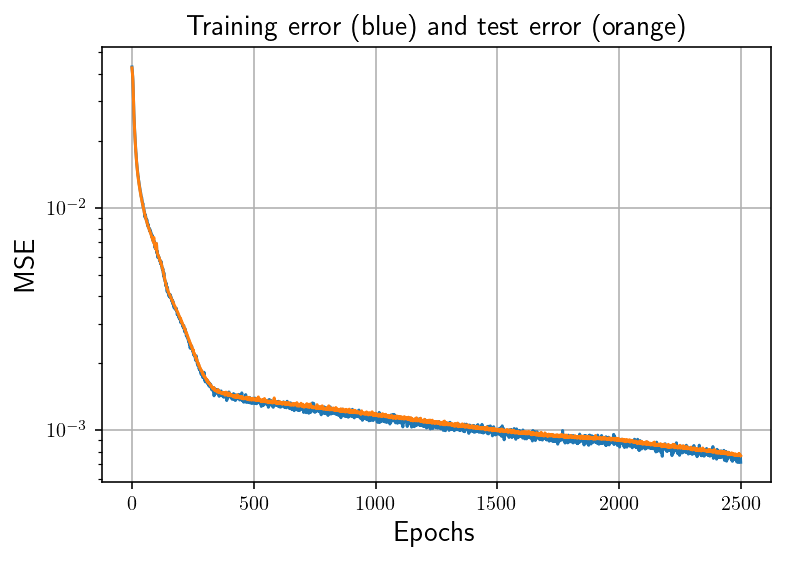

In [12]:
"""
Plot the training and validation MSE as a function of epochs
"""
plt.semilogy(np.array(train_loss))
plt.semilogy(np.array(test_loss))
plt.title('Training error (blue) and test error (orange)',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid(True)
plt.show()

In [13]:
# convert torch tensor to numpy 
rhat_test = rhat_test_.cpu().data.numpy().transpose(0,2,1)

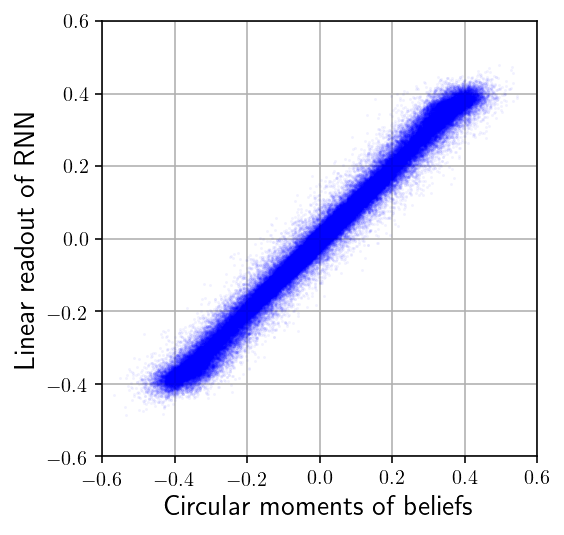

In [14]:
plt.plot(x_test[...,T_clip:].flatten(), rhat_test[...,T_clip:].flatten(),'b.',markersize=1,alpha=0.05)
plt.axis('square')
plt.axis([-.6,.6,-.6,.6])
plt.grid(True)
plt.xlabel('Circular moments of beliefs',fontsize=14)
plt.ylabel('Linear readout of RNN',fontsize=14)
plt.show()

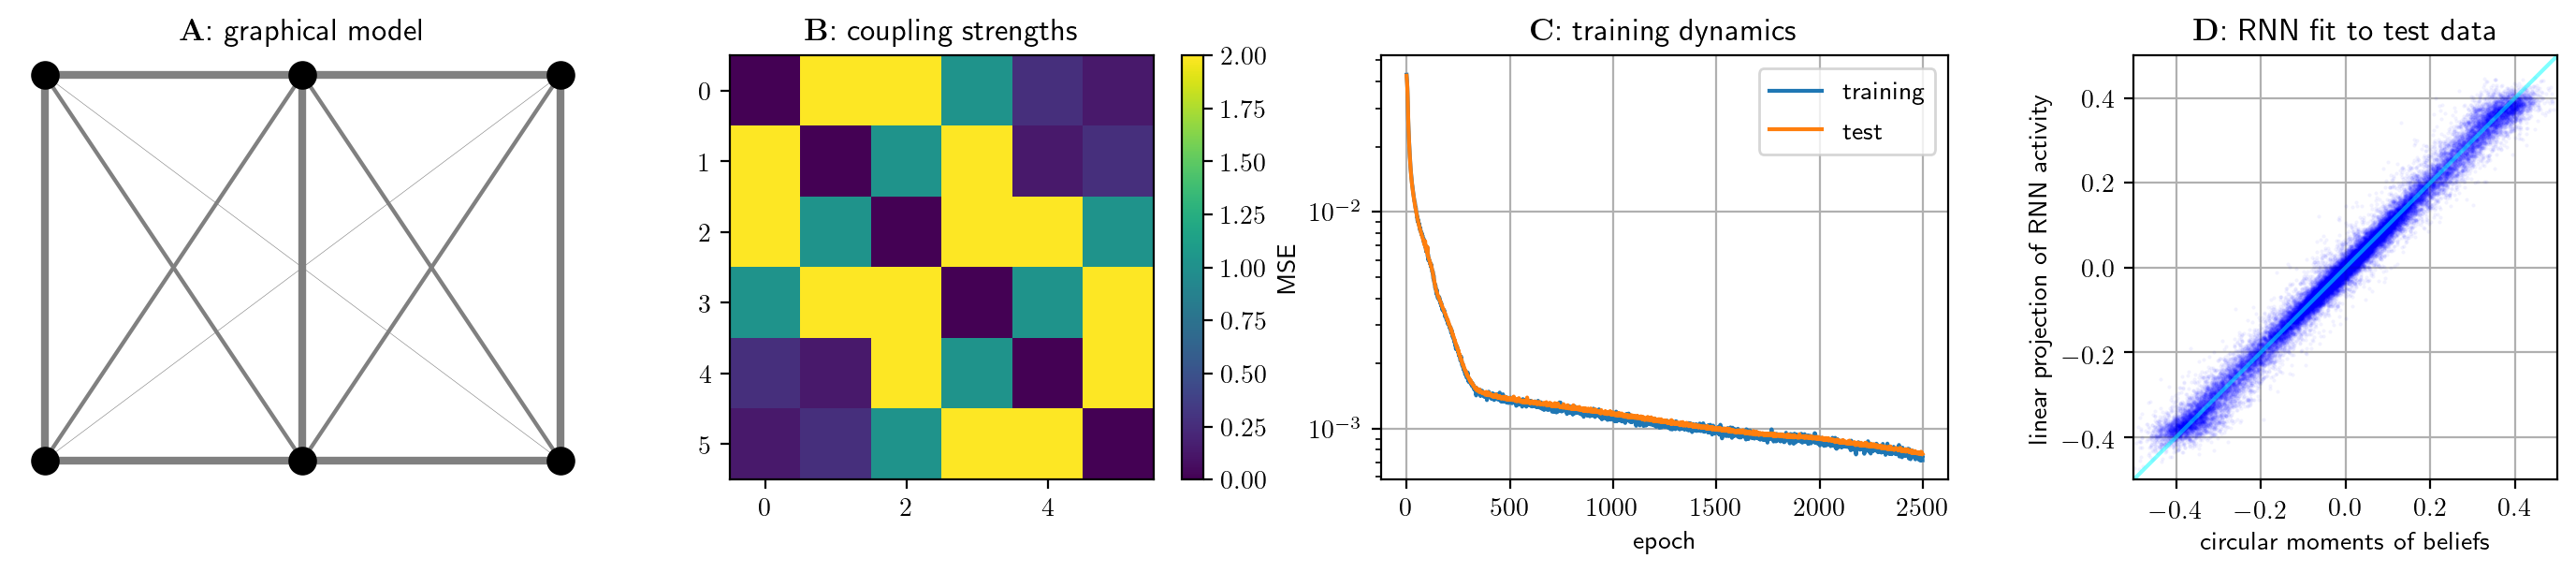

In [15]:
# Visualize dynamics of trained brain

J_max = np.max(J)
fig, ax = plt.subplots(1,4,figsize=(18,3),dpi=100)
for i in range(Ns):
    for j in range(i+1):
        if i != j:
            ax[0].plot([node_positions[i][0], node_positions[j][0]],[node_positions[i][1], node_positions[j][1]],color = 'gray', linewidth = 3*J[i,j,3]/J_max)

for k in range(Ns):
    ax[0].plot(node_positions[k][0],node_positions[k][1],'ko',markersize=10)
ax[0].axis('off')
ax[0].set(title = r'{\bf A}: graphical model')

pcm = ax[1].imshow(J[...,3])
ax[1].set(title = r'{\bf B}: coupling strengths')
fig.colorbar(pcm,ax=ax[1])


ax[2].semilogy(np.array(train_loss))
ax[2].semilogy(np.array(test_loss))
ax[2].set(title=r'{\bf C}: training dynamics',ylabel='MSE',xlabel='epoch')
ax[2].legend(['training', 'test'])
ax[2].grid(True)

ax[3].plot(x_test[0:50,:,T_clip:].flatten(), rhat_test[0:50,:,T_clip:].flatten(),'b.',markersize=1,alpha=0.05)
ax[3].set(title = r'{\bf D}: RNN fit to test data', xlabel='circular moments of beliefs', ylabel='linear projection of RNN activity')
ax[3].axis('square')
ax[3].plot([-.5,.5],[-.5,.5],color='cyan',alpha=0.5)
ax[3].axis([-.5,.5,-.5,.5])
ax[3].grid(True)

plt.show()